In [1]:
import Hartmannb
from botorch.models.transforms.input import Normalize

The result of custom_function at [0.95, 0.95, 0.95, 0.95, 0.95, 0.95] is 0.00011397265188861638


In [2]:
from botorch.test_functions.base import BaseTestProblem
from botorch.test_functions import Hartmann
import numpy as np 
import torch 
import random 
from botorch.models import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
# from botorch.fit import fit_gpytorch_model 
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

In [3]:
from scipy import stats
import matplotlib.pyplot as plt
from functools import partial
import torch.nn as nn
from botorch.models import MultiTaskGP
import scipy.stats
from botorch.acquisition import AcquisitionFunction
from botorch.acquisition import LogExpectedImprovement
import pandas as pd

In [4]:
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.acquisition import qLogNoisyExpectedImprovement
from botorch.acquisition import qLogExpectedImprovement
import os

In [5]:
# # 代码块1-生成初始训练集
# # 定义类对象
neg_hartmann6 = Hartmannb.Hartmann(dim=6, negate=True)
neg_hartmann6.optimal_value #3.32237
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [6]:
class NoisyHartmann6(Hartmannb.Hartmann):
    def __init__(self, dim=6, negate=True, noise_std=0.3):
        super().__init__(dim=dim, negate=negate)
        self.noise_std = noise_std

    def evaluate_true(self, X):
        # 计算原始的 Hartmann 函数值
        original_value = super().evaluate_true(X)
        # 添加噪声
        noise = torch.randn_like(original_value) * self.noise_std
        return original_value + noise

# 创建带噪声的 Hartmann6 函数实例
noisy_hartmann6 = NoisyHartmann6(noise_std=0.1)

In [7]:
obj = neg_hartmann6

In [8]:


# 设定随机种子以确保结果可复现（可选）
torch.manual_seed(42)

# 生成一千个随机样本
num_samples = 1000
random_inputs = torch.rand(num_samples, 6)  # 生成 1000 个 6 维的随机输入点

# 计算这些点的 neg_hartmann6 函数值
values = neg_hartmann6(random_inputs)

# 转换为 NumPy 数组以方便处理（可选）
values_np = values.numpy()

# 输出前 5 个值作为示例
print("Sample values from neg_hartmann6:")
print(random_inputs)

Sample values from neg_hartmann6:
tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408, 0.1332, 0.9346, 0.5936],
        [0.8694, 0.5677, 0.7411, 0.4294, 0.8854, 0.5739],
        ...,
        [0.8009, 0.8892, 0.4930, 0.8316, 0.5177, 0.0422],
        [0.7190, 0.1113, 0.5157, 0.0502, 0.2619, 0.3510],
        [0.3057, 0.0075, 0.2517, 0.0367, 0.0820, 0.0012]])


In [9]:
train_x = Hartmannb.generate_initial_samples(5,6,0,1)
print(train_x)

train_obj = neg_hartmann6(train_x).unsqueeze(-1)


print(train_obj)


tensor([[0.6313, 0.0984, 0.6081, 0.7539, 0.8265, 0.0674],
        [0.2062, 0.5659, 0.3623, 0.3837, 0.4151, 0.8065],
        [0.4213, 0.3659, 0.9086, 0.5569, 0.1698, 0.5887],
        [0.9941, 0.8291, 0.1857, 0.1732, 0.5728, 0.2889],
        [0.8553, 0.4016, 0.4780, 0.1181, 0.6557, 0.1262]], device='cuda:0',
       dtype=torch.float64)
tensor([[0.0080],
        [1.1220],
        [0.5675],
        [0.0089],
        [0.0090]], device='cuda:0', dtype=torch.float64)


In [11]:
dim = 6
n_samples = 1000

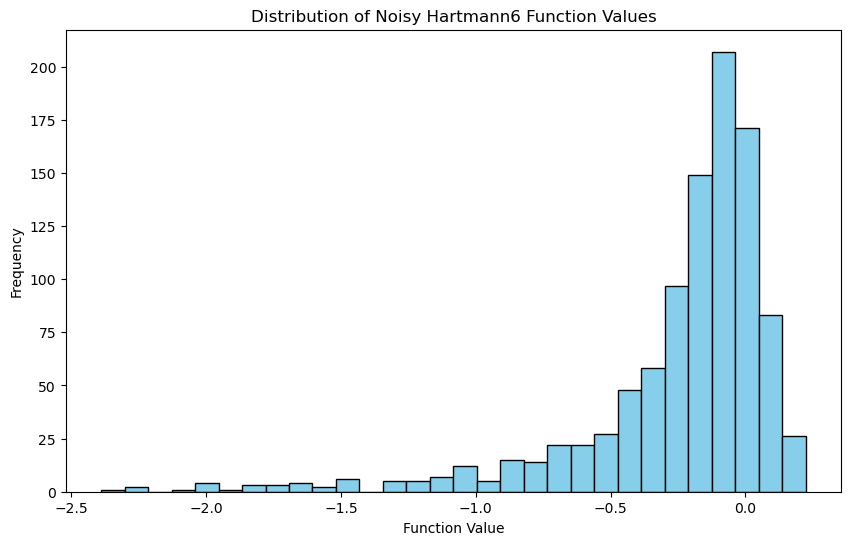

In [12]:
# 随机生成 1000 个 6 维点
random_points = torch.rand((n_samples, dim))

# 计算带噪声的 Hartmann6 函数值
noisy_hartmann_values = noisy_hartmann6.evaluate_true(random_points)

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.hist(noisy_hartmann_values.numpy(), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Noisy Hartmann6 Function Values")
plt.xlabel("Function Value")
plt.ylabel("Frequency")
plt.show()

In [10]:
initial_points_task11 = [Hartmannb.generate_initial_samples_with_custom_function2(5,5, 6, 0, 1, seed=i)[0] for i in range(10)]
initial_points_task22 = None  # 如果你没有任务2的初始点，可以设置为 None
initial_points_task23 = [Hartmannb.generate_initial_samples_with_custom_function2(20,20, 6, 0, 1, seed=i)[0] for i in range(20)]

In [11]:
initial_points_task11

[tensor([[0.4751, 0.5925, 0.4945, 0.3139, 0.9561, 0.0833],
         [0.6297, 0.4584, 0.8649, 0.9350, 0.1144, 0.6538],
         [0.8373, 0.8808, 0.1320, 0.1698, 0.3751, 0.9147],
         [0.0578, 0.0139, 0.5087, 0.5798, 0.5373, 0.3442],
         [0.2022, 0.8558, 0.8988, 0.6599, 0.6753, 0.1591]], device='cuda:0',
        dtype=torch.float64),
 tensor([[0.2677, 0.3618, 0.7123, 0.0310, 0.5429, 0.3926],
         [0.9479, 0.7943, 0.4245, 0.9344, 0.4640, 0.9529],
         [0.6642, 0.1215, 0.9293, 0.4735, 0.0331, 0.5994],
         [0.1100, 0.5345, 0.2152, 0.5701, 0.9543, 0.0548],
         [0.1840, 0.2014, 0.3655, 0.6349, 0.8609, 0.2681]], device='cuda:0',
        dtype=torch.float64),
 tensor([[0.7776, 0.9689, 0.0198, 0.6400, 0.9605, 0.2336],
         [0.4280, 0.3658, 0.8884, 0.3312, 0.2208, 0.7632],
         [0.1230, 0.7067, 0.4630, 0.9193, 0.3293, 0.5837],
         [0.7109, 0.0674, 0.5663, 0.1104, 0.5983, 0.4296],
         [0.5470, 0.5923, 0.8531, 0.1875, 0.6536, 0.0534]], device='cuda:0',
 

In [12]:
def fit_multi_task_gp_model_and_select_next_point(train_x, train_obj, device, task):
    input_dim = train_x.shape[1]
    outcome_dim = train_obj.shape[1]
    
    num_samples = train_x.size(0)
    task = task.expand(num_samples)  # 扩展 task 张量以匹配 train_x 的样本数

    # 将任务维度拼接到 train_x
    train_x_with_task = torch.cat([train_x, task.unsqueeze(-1)], dim=-1)

    # 修改 Normalize 变换的维度，以匹配拼接后的 train_x 维度
    input_transform = Normalize(d=train_x_with_task.shape[1])

    # 创建多任务模型，区分不同任务的训练数据
    model = MultiTaskGP(
        train_X=train_x_with_task,
        train_Y=train_obj,
        task_feature=train_x_with_task.shape[1] - 1,  # 任务特征索引
        input_transform=input_transform,  # 使用修改后的输入变换
        outcome_transform=Standardize(m=outcome_dim)
    ).to(device)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # 找到当前最优值
    best_value = train_obj.max()

    X_baseline = train_x[train_obj.flatten() == best_value.item()]

    qLogNEI = qLogNoisyExpectedImprovement(model=model, best_f=best_value, X_baseline=X_baseline)
    new_point_analytic, _ = optimize_acqf(
        acq_function=qLogNEI,
        bounds=torch.tensor([[0] * input_dim, [1] * input_dim], device=device, dtype=torch.float64),
        q=1,
        num_restarts=20,
        raw_samples=100,
        options={},
    )

    # 确保 new_point_analytic 是二维张量，形状为 (1, input_dim)
    new_point_analytic = new_point_analytic.unsqueeze(0)  # 确保形状为 (1, input_dim)

    return new_point_analytic

In [13]:
def fit_multi_task_gp_model_and_select_next_point1(train_x, train_obj, device, task):
    input_dim = train_x.shape[1]
    outcome_dim = train_obj.shape[1]
    
    num_samples = train_x.size(0)
    task = task.expand(num_samples)  # 扩展 task 张量以匹配 train_x 的样本数

    # 将任务维度拼接到 train_x
    train_x_with_task = torch.cat([train_x, task.unsqueeze(-1)], dim=-1)

    # 修改 Normalize 变换的维度，以匹配拼接后的 train_x 维度
    input_transform = Normalize(d=train_x_with_task.shape[1])

    # 创建和拟合多任务高斯过程模型
    model = MultiTaskGP(
        train_X=train_x_with_task,  # 使用拼接后的 train_x_with_task
        train_Y=train_obj,
        task_feature=-1,  # 假设最后一个维度是任务特征
        input_transform=input_transform,  # 使用匹配维度的 Normalize
        outcome_transform=Standardize(m=1),  # 假设输出为1维
    ).to(device)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # 找到当前最优值
    best_value = train_obj.max()

    # 使用 ScalarizedPosteriorTransform 来标量化多输出模型
    weights = torch.ones(1, device=device)  # 假设输出为1维
    posterior_transform = ScalarizedPosteriorTransform(weights=weights)

    # 使用 qLogExpectedImprovement 选择下一个采样点
    qLogEI = qLogExpectedImprovement(model=model, best_f=best_value, posterior_transform=posterior_transform)

    # 修改上下界为 Ackley 函数的上下界 [-32.768, 32.768]
    lower_bounds = [0] * input_dim  # 根据输入的维度设置下界
    upper_bounds = [1] * input_dim   # 根据输入的维度设置上界
    
    bounds = torch.tensor([lower_bounds, upper_bounds], device=device, dtype=torch.float64)

    new_point_analytic, _ = optimize_acqf(
        acq_function=qLogEI,
        bounds=bounds,
        q=1,  # 采样一个点
        num_restarts=20,
        raw_samples=100,
        options={},
    )
    
    return new_point_analytic.squeeze(0)

In [14]:
results0 = Hartmannb.bayesian_optimization_experiment(
    num_experiments=10,
    n=25,
    obj_fn1=noisy_hartmann6,
    obj_fn2=Hartmannb.offline_hartmann6,
    obj_fn3=obj,
    initial_points_task1=initial_points_task11,  # 传递生成的初始样本
    initial_points_task2=initial_points_task23,  # 传递生成的初始样本
    fit_task_fn=fit_multi_task_gp_model_and_select_next_point,
    device='cuda',
    task_type='multi'
)

tensor([[4.7511e-01, 5.9252e-01, 4.9448e-01, 3.1385e-01, 9.5609e-01, 8.3302e-02],
        [6.2970e-01, 4.5839e-01, 8.6488e-01, 9.3503e-01, 1.1441e-01, 6.5383e-01],
        [8.3730e-01, 8.8081e-01, 1.3197e-01, 1.6978e-01, 3.7511e-01, 9.1470e-01],
        [5.7806e-02, 1.3852e-02, 5.0866e-01, 5.7984e-01, 5.3730e-01, 3.4417e-01],
        [2.0219e-01, 8.5580e-01, 8.9877e-01, 6.5989e-01, 6.7529e-01, 1.5911e-01],
        [4.7511e-01, 5.9252e-01, 4.9448e-01, 3.1385e-01, 9.5609e-01, 8.3302e-02],
        [6.2970e-01, 4.5839e-01, 8.6488e-01, 9.3503e-01, 1.1441e-01, 6.5383e-01],
        [8.3730e-01, 8.8081e-01, 1.3197e-01, 1.6978e-01, 3.7511e-01, 9.1470e-01],
        [5.7806e-02, 1.3852e-02, 5.0866e-01, 5.7984e-01, 5.3730e-01, 3.4417e-01],
        [2.0219e-01, 8.5580e-01, 8.9877e-01, 6.5989e-01, 6.7529e-01, 1.5911e-01],
        [9.1931e-01, 2.2611e-01, 2.7308e-01, 9.3388e-02, 2.7082e-01, 6.0366e-01],
        [6.1028e-01, 6.7882e-01, 7.2377e-01, 8.2716e-01, 2.1916e-01, 8.4280e-01],
        [2.6831e

C:\Users\10925\AppData\Roaming\Python\Python311\site-packages\linear_operator\utils\interpolation.py:71: UserWarning:

The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:80.)

C:\Users\10925\AppData\Roaming\Python\Python311\site-packages\linear_operator\utils\interpolation.py:71: UserWarning:

torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:623.)

F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch

Nr. of optimization run: 0
New candidates are: tensor([[0.2739, 0.7814, 0.8326, 0.5630, 0.7554, 0.0943]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 1.88 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 1
New candidates are: tensor([[0.3046, 0.7059, 0.9334, 0.5948, 0.6986, 0.1057]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 1.36 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 2
New candidates are: tensor([[0.3137, 0.6870, 0.9243, 0.5692, 0.7027, 0.1103]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 0.97 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 3
New candidates are: tensor([[0.3209, 0.6748, 0.9102, 0.5520, 0.7057, 0.1111]], device='cuda:0',
       dtype=torch.float64)
Iteration 3 took 1.00 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 4
New candidates are: tensor([[0.3296, 0.7060, 0.9395, 0.6067, 0.7421, 0.0893]], device='cuda:0',
       dtype=torch.float64)
Iteration 4 took 0.94 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 5
New candidates are: tensor([[0.3254, 0.7691, 0.8776, 0.5063, 0.7798, 0.0483]], device='cuda:0',
       dtype=torch.float64)
Iteration 5 took 1.11 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 6
New candidates are: tensor([[0.3390, 0.7242, 0.9167, 0.6461, 0.8098, 0.0584]], device='cuda:0',
       dtype=torch.float64)
Iteration 6 took 1.39 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 7
New candidates are: tensor([[0.3412, 0.7289, 0.9202, 0.6446, 0.8081, 0.0593]], device='cuda:0',
       dtype=torch.float64)
Iteration 7 took 1.50 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 8
New candidates are: tensor([[0.3087, 0.7162, 0.9224, 0.6331, 0.8049, 0.0605]], device='cuda:0',
       dtype=torch.float64)
Iteration 8 took 2.12 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 9
New candidates are: tensor([[0.4129, 0.7603, 0.9082, 0.6313, 0.7859, 0.0622]], device='cuda:0',
       dtype=torch.float64)
Iteration 9 took 2.33 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 10
New candidates are: tensor([[0.4782, 0.8232, 0.9282, 0.5500, 0.7810, 0.0257]], device='cuda:0',
       dtype=torch.float64)
Iteration 10 took 1.20 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 11
New candidates are: tensor([[0.4889, 0.8238, 0.9231, 0.5645, 0.7807, 0.0268]], device='cuda:0',
       dtype=torch.float64)
Iteration 11 took 1.53 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 12
New candidates are: tensor([[0.4918, 0.8227, 0.9208, 0.5709, 0.7803, 0.0292]], device='cuda:0',
       dtype=torch.float64)
Iteration 12 took 2.19 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 13
New candidates are: tensor([[0.4944, 0.8225, 0.9195, 0.5749, 0.7796, 0.0307]], device='cuda:0',
       dtype=torch.float64)
Iteration 13 took 2.27 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 14
New candidates are: tensor([[0.4965, 0.8214, 0.9177, 0.5799, 0.7790, 0.0329]], device='cuda:0',
       dtype=torch.float64)
Iteration 14 took 1.34 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 15
New candidates are: tensor([[0.4963, 0.8207, 0.9175, 0.5814, 0.7787, 0.0339]], device='cuda:0',
       dtype=torch.float64)
Iteration 15 took 1.98 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 16
New candidates are: tensor([[0.4931, 0.8199, 0.9188, 0.5798, 0.7789, 0.0337]], device='cuda:0',
       dtype=torch.float64)
Iteration 16 took 1.89 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 17
New candidates are: tensor([[0.4865, 0.8197, 0.9221, 0.5718, 0.7803, 0.0304]], device='cuda:0',
       dtype=torch.float64)
Iteration 17 took 2.03 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 18
New candidates are: tensor([[0.5056, 0.7861, 0.8486, 0.6370, 0.7588, 0.0000]], device='cuda:0',
       dtype=torch.float64)
Iteration 18 took 1.80 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 19
New candidates are: tensor([[0.4860, 0.8415, 0.9740, 0.5441, 0.8098, 0.0847]], device='cuda:0',
       dtype=torch.float64)
Iteration 19 took 1.81 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 20
New candidates are: tensor([[0.4428, 0.8673, 1.0000, 0.5644, 0.7782, 0.0365]], device='cuda:0',
       dtype=torch.float64)
Iteration 20 took 3.67 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 21
New candidates are: tensor([[0.4536, 0.8981, 1.0000, 0.5501, 0.8184, 0.0837]], device='cuda:0',
       dtype=torch.float64)
Iteration 21 took 2.69 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 22
New candidates are: tensor([[0.4800, 0.8181, 1.0000, 0.4982, 0.8049, 0.0655]], device='cuda:0',
       dtype=torch.float64)
Iteration 22 took 2.25 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 23
New candidates are: tensor([[0.4767, 0.8649, 1.0000, 0.6054, 0.7766, 0.0905]], device='cuda:0',
       dtype=torch.float64)
Iteration 23 took 2.44 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 24
New candidates are: tensor([[0.4720, 0.8566, 0.9864, 0.5851, 0.7868, 0.0884]], device='cuda:0',
       dtype=torch.float64)
Iteration 24 took 4.59 seconds
最优点: [0.6985925495990674, 0.6985925495990674, 0.6985925495990674, 0.6985925495990674, 1.16420343697261, 2.0232770513354295, 2.0232770513354295, 2.0232770513354295, 2.0232770513354295, 2.075920243918041, 2.3654667112844, 2.3654667112844, 2.3654667112844, 2.3654667112844, 2.6007894316162936, 2.69056034298847, 2.69056034298847, 2.69056034298847, 2.69056034298847, 2.69056034298847, 2.69056034298847, 2.69056034298847, 2.69056034298847, 2.69056034298847, 2.69056034298847, 2.9744569406590755, 2.9744569406590755, 2.9744569406590755, 2.9744569406590755, 2.9744569406590755]
tensor([[0.2677, 0.3618, 0.7123, 0.0310, 0.5429, 0.3926],
        [0.9479, 0.7943, 0.4245, 0.9344, 0.4640, 0.9529],
        [0.6642, 0.1215, 0.9293, 0.4735, 0.0331, 0.5994],
        [0.1100, 0.5345, 0.2152, 0.5701, 0.9543, 0.0548],
        [0.184

F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 0
New candidates are: tensor([[0.3128, 0.5368, 0.7124, 0.1292, 0.4818, 0.3342]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 0.56 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 1
New candidates are: tensor([[0.2932, 0.4582, 0.7197, 0.0828, 0.5086, 0.3545]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 1.00 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 2
New candidates are: tensor([[0.2918, 0.4500, 0.7200, 0.0792, 0.5112, 0.3572]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 0.58 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 3
New candidates are: tensor([[0.2928, 0.4484, 0.7227, 0.0788, 0.5115, 0.3562]], device='cuda:0',
       dtype=torch.float64)
Iteration 3 took 1.22 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 4
New candidates are: tensor([[0.3567, 0.7132, 0.7081, 0.2157, 0.4658, 0.2847]], device='cuda:0',
       dtype=torch.float64)
Iteration 4 took 0.80 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 5
New candidates are: tensor([[0.3548, 0.5800, 0.6470, 0.2184, 0.3279, 0.4168]], device='cuda:0',
       dtype=torch.float64)
Iteration 5 took 0.91 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 6
New candidates are: tensor([[0.3652, 0.5893, 0.6314, 0.2367, 0.2866, 0.4376]], device='cuda:0',
       dtype=torch.float64)
Iteration 6 took 0.88 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 7
New candidates are: tensor([[0.3707, 0.5932, 0.6235, 0.2468, 0.2664, 0.4493]], device='cuda:0',
       dtype=torch.float64)
Iteration 7 took 0.72 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 8
New candidates are: tensor([[0.3719, 0.5968, 0.6187, 0.2530, 0.2600, 0.4515]], device='cuda:0',
       dtype=torch.float64)
Iteration 8 took 1.20 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 9
New candidates are: tensor([[0.3746, 0.6000, 0.6134, 0.2600, 0.2495, 0.4571]], device='cuda:0',
       dtype=torch.float64)
Iteration 9 took 0.70 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 10
New candidates are: tensor([[0.3762, 0.6021, 0.6103, 0.2644, 0.2440, 0.4601]], device='cuda:0',
       dtype=torch.float64)
Iteration 10 took 0.75 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 11
New candidates are: tensor([[0.3757, 0.6036, 0.6084, 0.2666, 0.2442, 0.4589]], device='cuda:0',
       dtype=torch.float64)
Iteration 11 took 0.67 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 12
New candidates are: tensor([[0.3206, 0.6345, 0.5167, 0.2989, 0.2509, 0.3460]], device='cuda:0',
       dtype=torch.float64)
Iteration 12 took 1.75 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 13
New candidates are: tensor([[0.3737, 0.7825, 0.5729, 0.3095, 0.2397, 0.3821]], device='cuda:0',
       dtype=torch.float64)
Iteration 13 took 0.97 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 14
New candidates are: tensor([[0.3075, 0.4861, 0.5438, 0.3037, 0.2715, 0.4184]], device='cuda:0',
       dtype=torch.float64)
Iteration 14 took 1.09 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 15
New candidates are: tensor([[0.3962, 0.5692, 0.6190, 0.2759, 0.2046, 0.5104]], device='cuda:0',
       dtype=torch.float64)
Iteration 15 took 0.97 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 16
New candidates are: tensor([[0.3163, 0.4908, 0.5571, 0.3106, 0.2562, 0.4365]], device='cuda:0',
       dtype=torch.float64)
Iteration 16 took 0.97 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 17
New candidates are: tensor([[0.3186, 0.4998, 0.5565, 0.3106, 0.2602, 0.4340]], device='cuda:0',
       dtype=torch.float64)
Iteration 17 took 0.72 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 18
New candidates are: tensor([[0.3192, 0.4880, 0.5593, 0.3165, 0.2541, 0.4447]], device='cuda:0',
       dtype=torch.float64)
Iteration 18 took 0.81 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 19
New candidates are: tensor([[0.3685, 0.4414, 0.6060, 0.2922, 0.1496, 0.5472]], device='cuda:0',
       dtype=torch.float64)
Iteration 19 took 0.80 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 20
New candidates are: tensor([[0.3409, 0.4841, 0.5910, 0.3536, 0.2419, 0.4900]], device='cuda:0',
       dtype=torch.float64)
Iteration 20 took 1.56 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 21
New candidates are: tensor([[0.3428, 0.4797, 0.5982, 0.3581, 0.2369, 0.4987]], device='cuda:0',
       dtype=torch.float64)
Iteration 21 took 1.09 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 22
New candidates are: tensor([[0.3441, 0.4781, 0.6026, 0.3611, 0.2352, 0.5033]], device='cuda:0',
       dtype=torch.float64)
Iteration 22 took 1.08 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 23
New candidates are: tensor([[0.3449, 0.4784, 0.5998, 0.3602, 0.2352, 0.5030]], device='cuda:0',
       dtype=torch.float64)
Iteration 23 took 1.05 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 24
New candidates are: tensor([[0.3455, 0.4790, 0.5935, 0.3582, 0.2357, 0.5018]], device='cuda:0',
       dtype=torch.float64)
Iteration 24 took 1.30 seconds
最优点: [0.5395971097024563, 0.5395971097024563, 0.5395971097024563, 0.5395971097024563, 0.5395971097024563, 0.5395971097024563, 0.5395971097024563, 0.5395971097024563, 0.5395971097024563, 0.5395971097024563, 0.9372579847397163, 0.9905922827484371, 1.0013656949349719, 1.0013656949349719, 1.0013656949349719, 1.0013656949349719, 1.0013656949349719, 1.0013656949349719, 1.0013656949349719, 1.3504935198605628, 1.3504935198605628, 1.3634508925440083, 1.3634508925440083, 1.391399513509304, 1.391399513509304, 1.4352095502854572, 1.4436808205081384, 1.4453580900374265, 1.447345286652928, 1.4535458866852322]
tensor([[0.7776, 0.9689, 0.0198, 0.6400, 0.9605, 0.2336],
        [0.4280, 0.3658, 0.8884, 0.3312, 0.2208, 0.7632],
        [0.1230, 0.7067, 0.4630, 0.9193, 0.3293, 0.5837],
        [0.7109, 0.0674, 0.5663, 0.1104,

F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 0
New candidates are: tensor([[0.4350, 0.3308, 0.8896, 0.2833, 0.2531, 0.6669]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 2.59 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 1
New candidates are: tensor([[0.4357, 0.3324, 0.8904, 0.2800, 0.2536, 0.6652]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 2.33 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 2
New candidates are: tensor([[0.4227, 0.2973, 0.8662, 0.2947, 0.2287, 0.6978]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 2.78 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 3
New candidates are: tensor([[0.4201, 0.2816, 0.8639, 0.3023, 0.2156, 0.7230]], device='cuda:0',
       dtype=torch.float64)
Iteration 3 took 2.78 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 4
New candidates are: tensor([[0.4237, 0.2813, 0.8662, 0.3058, 0.2192, 0.7239]], device='cuda:0',
       dtype=torch.float64)
Iteration 4 took 1.61 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 5
New candidates are: tensor([[0.4431, 0.3025, 0.8392, 0.3029, 0.1956, 0.7108]], device='cuda:0',
       dtype=torch.float64)
Iteration 5 took 4.26 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 6
New candidates are: tensor([[0.4509, 0.3085, 0.8390, 0.3085, 0.1781, 0.7142]], device='cuda:0',
       dtype=torch.float64)
Iteration 6 took 2.81 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 7
New candidates are: tensor([[0.3982, 0.2970, 0.8693, 0.3077, 0.2771, 0.7440]], device='cuda:0',
       dtype=torch.float64)
Iteration 7 took 2.28 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 8
New candidates are: tensor([[0.3903, 0.2995, 0.8732, 0.3126, 0.2890, 0.7556]], device='cuda:0',
       dtype=torch.float64)
Iteration 8 took 3.89 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 9
New candidates are: tensor([[0.3889, 0.3024, 0.8757, 0.3152, 0.2892, 0.7572]], device='cuda:0',
       dtype=torch.float64)
Iteration 9 took 1.31 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 10
New candidates are: tensor([[0.3876, 0.3048, 0.8775, 0.3175, 0.2896, 0.7588]], device='cuda:0',
       dtype=torch.float64)
Iteration 10 took 1.55 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 11
New candidates are: tensor([[0.3812, 0.3102, 0.8833, 0.3238, 0.2967, 0.7690]], device='cuda:0',
       dtype=torch.float64)
Iteration 11 took 3.16 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 12
New candidates are: tensor([[0.3846, 0.3093, 0.8793, 0.3213, 0.2939, 0.7653]], device='cuda:0',
       dtype=torch.float64)
Iteration 12 took 1.27 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 13
New candidates are: tensor([[0.3841, 0.3123, 0.8807, 0.3233, 0.2939, 0.7678]], device='cuda:0',
       dtype=torch.float64)
Iteration 13 took 1.97 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 14
New candidates are: tensor([[0.3817, 0.3166, 0.8830, 0.3270, 0.2962, 0.7725]], device='cuda:0',
       dtype=torch.float64)
Iteration 14 took 1.86 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 15
New candidates are: tensor([[0.3797, 0.3195, 0.8845, 0.3298, 0.2978, 0.7750]], device='cuda:0',
       dtype=torch.float64)
Iteration 15 took 1.83 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 16
New candidates are: tensor([[0.3825, 0.3181, 0.8828, 0.3273, 0.2960, 0.7743]], device='cuda:0',
       dtype=torch.float64)
Iteration 16 took 1.86 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 17
New candidates are: tensor([[0.3839, 0.3177, 0.8823, 0.3265, 0.2942, 0.7732]], device='cuda:0',
       dtype=torch.float64)
Iteration 17 took 2.20 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 18
New candidates are: tensor([[0.3841, 0.3186, 0.8820, 0.3269, 0.2941, 0.7735]], device='cuda:0',
       dtype=torch.float64)
Iteration 18 took 3.30 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 19
New candidates are: tensor([[0.3858, 0.3144, 0.8817, 0.3237, 0.2902, 0.7686]], device='cuda:0',
       dtype=torch.float64)
Iteration 19 took 1.94 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 20
New candidates are: tensor([[0.3874, 0.3138, 0.8774, 0.3234, 0.2914, 0.7644]], device='cuda:0',
       dtype=torch.float64)
Iteration 20 took 3.23 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 21
New candidates are: tensor([[0.3871, 0.3133, 0.8804, 0.3220, 0.2884, 0.7669]], device='cuda:0',
       dtype=torch.float64)
Iteration 21 took 5.44 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 22
New candidates are: tensor([[0.3886, 0.3119, 0.8772, 0.3256, 0.2898, 0.7552]], device='cuda:0',
       dtype=torch.float64)
Iteration 22 took 2.28 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 23
New candidates are: tensor([[0.3991, 0.3111, 0.8833, 0.3201, 0.2945, 0.7746]], device='cuda:0',
       dtype=torch.float64)
Iteration 23 took 3.69 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 24
New candidates are: tensor([[0.3696, 0.3192, 0.8790, 0.3272, 0.2657, 0.7440]], device='cuda:0',
       dtype=torch.float64)
Iteration 24 took 2.97 seconds
最优点: [0.14270752358911953, 1.58733569963281, 1.58733569963281, 1.58733569963281, 1.58733569963281, 1.5890638888554847, 1.5890638888554847, 1.7083344087998307, 1.713236568878962, 1.713236568878962, 1.713236568878962, 1.713236568878962, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894, 1.868307640997894]
tensor([[0.0685, 0.2245, 0.6992, 0.0626, 0.3754, 0.0304],
        [0.9705, 0.7464, 0.3596, 0.6219, 0.6364, 0.9877],
        [0.6601, 0.3025, 0.8648, 0.4429, 0.8308, 0.5294],
        [0.2541, 0.7934, 0.2013, 0.9934, 0.0870, 0.4867],
        

F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 0
New candidates are: tensor([[1., 0., 0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)
Iteration 0 took 0.95 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 1
New candidates are: tensor([[0.5403, 0.2009, 0.3992, 0.1668, 0.0256, 0.9409]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 0.73 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 2
New candidates are: tensor([[1., 0., 0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)
Iteration 2 took 0.88 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 3
New candidates are: tensor([[1., 0., 0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)
Iteration 3 took 0.84 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 4
New candidates are: tensor([[1., 0., 0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)
Iteration 4 took 0.92 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 5
New candidates are: tensor([[0.9815, 0.0000, 0.0164, 0.0000, 0.0000, 1.0000]], device='cuda:0',
       dtype=torch.float64)
Iteration 5 took 0.89 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 6
New candidates are: tensor([[0.5411, 0.2259, 0.3904, 0.1849, 0.0632, 0.9098]], device='cuda:0',
       dtype=torch.float64)
Iteration 6 took 0.98 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 7
New candidates are: tensor([[0.3664, 0.5105, 0.4121, 0.2915, 0.3369, 0.8577]], device='cuda:0',
       dtype=torch.float64)
Iteration 7 took 0.83 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 8
New candidates are: tensor([[0.3620, 0.5122, 0.4205, 0.2982, 0.3340, 0.8540]], device='cuda:0',
       dtype=torch.float64)
Iteration 8 took 0.62 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 9
New candidates are: tensor([[0.3604, 0.5118, 0.4251, 0.3015, 0.3312, 0.8517]], device='cuda:0',
       dtype=torch.float64)
Iteration 9 took 0.74 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 10
New candidates are: tensor([[0.3586, 0.5104, 0.4311, 0.3054, 0.3265, 0.8487]], device='cuda:0',
       dtype=torch.float64)
Iteration 10 took 0.80 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 11
New candidates are: tensor([[0.3566, 0.5092, 0.4377, 0.3100, 0.3219, 0.8448]], device='cuda:0',
       dtype=torch.float64)
Iteration 11 took 0.83 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 12
New candidates are: tensor([[0.3547, 0.5086, 0.4436, 0.3145, 0.3186, 0.8410]], device='cuda:0',
       dtype=torch.float64)
Iteration 12 took 0.88 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 13
New candidates are: tensor([[0.3521, 0.5077, 0.4523, 0.3213, 0.3138, 0.8350]], device='cuda:0',
       dtype=torch.float64)
Iteration 13 took 0.70 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 14
New candidates are: tensor([[0.3479, 0.5065, 0.4657, 0.3320, 0.3068, 0.8250]], device='cuda:0',
       dtype=torch.float64)
Iteration 14 took 0.77 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 15
New candidates are: tensor([[0.3467, 0.5069, 0.4698, 0.3359, 0.3061, 0.8214]], device='cuda:0',
       dtype=torch.float64)
Iteration 15 took 0.78 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 16
New candidates are: tensor([[0.3444, 0.5072, 0.4775, 0.3432, 0.3040, 0.8144]], device='cuda:0',
       dtype=torch.float64)
Iteration 16 took 0.72 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 17
New candidates are: tensor([[0.3409, 0.5078, 0.4895, 0.3549, 0.3012, 0.8024]], device='cuda:0',
       dtype=torch.float64)
Iteration 17 took 0.59 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 18
New candidates are: tensor([[0.3411, 0.5085, 0.4895, 0.3555, 0.3025, 0.8020]], device='cuda:0',
       dtype=torch.float64)
Iteration 18 took 0.80 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 19
New candidates are: tensor([[0.3443, 0.5079, 0.4789, 0.3443, 0.3046, 0.8147]], device='cuda:0',
       dtype=torch.float64)
Iteration 19 took 0.80 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 20
New candidates are: tensor([[0.3410, 0.5084, 0.4905, 0.3549, 0.3014, 0.8052]], device='cuda:0',
       dtype=torch.float64)
Iteration 20 took 0.88 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 21
New candidates are: tensor([[0.3382, 0.5097, 0.5004, 0.3654, 0.3007, 0.7954]], device='cuda:0',
       dtype=torch.float64)
Iteration 21 took 1.03 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 22
New candidates are: tensor([[0.3356, 0.5119, 0.5105, 0.3774, 0.3022, 0.7834]], device='cuda:0',
       dtype=torch.float64)
Iteration 22 took 0.88 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 23
New candidates are: tensor([[0.3348, 0.5136, 0.5146, 0.3836, 0.3048, 0.7768]], device='cuda:0',
       dtype=torch.float64)
Iteration 23 took 0.69 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 24
New candidates are: tensor([[0.3345, 0.5150, 0.5170, 0.3879, 0.3074, 0.7721]], device='cuda:0',
       dtype=torch.float64)
Iteration 24 took 1.25 seconds
最优点: [0.08857418652653962, 0.08857418652653962, 0.08857418652653962, 0.08857418652653962, 0.24221774023183704, 0.24221774023183704, 0.32207466481028024, 0.32207466481028024, 0.32207466481028024, 0.32207466481028024, 0.32207466481028024, 0.4997807538285009, 1.4020396194788831, 1.423756224198263, 1.4411343984837204, 1.4672650427896483, 1.4944512083419303, 1.5163180402695542, 1.5475954210709724, 1.5915076015139415, 1.600648140148267, 1.6191943568350535, 1.6432542667920371, 1.6432542667920371, 1.6432542667920371, 1.6432542667920371, 1.6432542667920371, 1.6432542667920371, 1.6432542667920371, 1.6432542667920371]
tensor([[8.1273e-01, 4.1567e-01, 4.2341e-01, 2.8256e-01, 3.6023e-01, 3.4499e-01],
        [9.1593e-02, 6.9233e-01, 7.5126e-01, 6.6211e-01, 7.3130e-01, 7.6917e-01],
        [4.0922e-01, 1.5361e-01, 2.125

F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 0
New candidates are: tensor([[0.5227, 0.4663, 0.6165, 0.3174, 0.1547, 0.7457]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 1.20 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 1
New candidates are: tensor([[0.5250, 0.4478, 0.7064, 0.3277, 0.2000, 0.7681]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 0.77 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 2
New candidates are: tensor([[0.5253, 0.4402, 0.7308, 0.3324, 0.2153, 0.7730]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 0.73 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 3
New candidates are: tensor([[0.4092, 0.4390, 0.8848, 0.3717, 0.2382, 0.8129]], device='cuda:0',
       dtype=torch.float64)
Iteration 3 took 2.09 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 4
New candidates are: tensor([[0.4123, 0.4376, 0.8834, 0.3727, 0.2420, 0.8102]], device='cuda:0',
       dtype=torch.float64)
Iteration 4 took 1.11 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 5
New candidates are: tensor([[0.4148, 0.4343, 0.8816, 0.3748, 0.2491, 0.8069]], device='cuda:0',
       dtype=torch.float64)
Iteration 5 took 1.17 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 6
New candidates are: tensor([[0.4232, 0.4258, 0.8734, 0.3783, 0.2631, 0.7994]], device='cuda:0',
       dtype=torch.float64)
Iteration 6 took 1.05 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 7
New candidates are: tensor([[0.4254, 0.4221, 0.8708, 0.3808, 0.2698, 0.7959]], device='cuda:0',
       dtype=torch.float64)
Iteration 7 took 1.69 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 8
New candidates are: tensor([[0.4308, 0.4196, 0.8670, 0.3813, 0.2731, 0.7934]], device='cuda:0',
       dtype=torch.float64)
Iteration 8 took 1.14 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 9
New candidates are: tensor([[0.4245, 0.4373, 0.8859, 0.3710, 0.2476, 0.8103]], device='cuda:0',
       dtype=torch.float64)
Iteration 9 took 1.50 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 10
New candidates are: tensor([[0.4276, 0.4385, 0.8880, 0.3702, 0.2473, 0.8112]], device='cuda:0',
       dtype=torch.float64)
Iteration 10 took 1.00 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 11
New candidates are: tensor([[0.4373, 0.4419, 0.8952, 0.3673, 0.2448, 0.8159]], device='cuda:0',
       dtype=torch.float64)
Iteration 11 took 1.48 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 12
New candidates are: tensor([[0.4258, 0.4379, 0.8849, 0.3693, 0.2494, 0.8072]], device='cuda:0',
       dtype=torch.float64)
Iteration 12 took 1.16 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 13
New candidates are: tensor([[0.4184, 0.4300, 0.8662, 0.3786, 0.2516, 0.8138]], device='cuda:0',
       dtype=torch.float64)
Iteration 13 took 1.70 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 14
New candidates are: tensor([[0.4345, 0.4399, 0.9046, 0.3672, 0.2425, 0.7740]], device='cuda:0',
       dtype=torch.float64)
Iteration 14 took 0.88 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 15
New candidates are: tensor([[0.4240, 0.4204, 0.8202, 0.3752, 0.2646, 0.8764]], device='cuda:0',
       dtype=torch.float64)
Iteration 15 took 1.64 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 16
New candidates are: tensor([[0.4314, 0.4156, 0.8061, 0.3744, 0.2682, 0.8890]], device='cuda:0',
       dtype=torch.float64)
Iteration 16 took 1.14 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 17
New candidates are: tensor([[0.4348, 0.4137, 0.8009, 0.3741, 0.2694, 0.8935]], device='cuda:0',
       dtype=torch.float64)
Iteration 17 took 1.41 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 18
New candidates are: tensor([[0.4367, 0.4130, 0.7987, 0.3738, 0.2698, 0.8949]], device='cuda:0',
       dtype=torch.float64)
Iteration 18 took 1.25 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 19
New candidates are: tensor([[0.5595, 0.3606, 0.7564, 0.3850, 0.2658, 0.8192]], device='cuda:0',
       dtype=torch.float64)
Iteration 19 took 1.28 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 20
New candidates are: tensor([[0.3897, 0.4118, 0.7646, 0.3062, 0.2976, 0.8342]], device='cuda:0',
       dtype=torch.float64)
Iteration 20 took 2.26 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 21
New candidates are: tensor([[0.4559, 0.4418, 0.7808, 0.3637, 0.2590, 0.9189]], device='cuda:0',
       dtype=torch.float64)
Iteration 21 took 1.05 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 22
New candidates are: tensor([[0.4518, 0.4393, 0.7812, 0.3634, 0.2593, 0.9181]], device='cuda:0',
       dtype=torch.float64)
Iteration 22 took 1.22 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 23
New candidates are: tensor([[0.4313, 0.4266, 0.7690, 0.3816, 0.2600, 0.8861]], device='cuda:0',
       dtype=torch.float64)
Iteration 23 took 1.20 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 24
New candidates are: tensor([[0.4116, 0.4263, 0.7446, 0.3890, 0.2720, 0.8776]], device='cuda:0',
       dtype=torch.float64)
Iteration 24 took 2.50 seconds
最优点: [0.35914601013046926, 0.35914601013046926, 0.35914601013046926, 0.35914601013046926, 0.35914601013046926, 1.1844535211811058, 1.4549299328725251, 1.518576947258218, 1.5206639135542888, 1.5231611620346124, 1.5302195653926747, 1.5530276538858176, 1.5572857197646548, 1.5618913324296773, 1.5618913324296773, 1.5618913324296773, 1.5618913324296773, 1.5618913324296773, 1.5772448412835263, 1.5772448412835263, 1.6991710533343145, 1.7050237387428426, 1.7050237387428426, 1.7050237387428426, 1.7050237387428426, 1.9062577025670269, 1.9062577025670269, 1.9062577025670269, 1.9062577025670269, 1.9062577025670269]
tensor([[0.4803, 0.1173, 0.1240, 0.3462, 0.2135, 0.5481],
        [0.9058, 0.6139, 0.6967, 0.6596, 0.8671, 0.4308],
        [0.6665, 0.2585, 0.3313, 0.1009, 0.7079, 0.1227],
        [0.2170, 0.7541, 0.9735, 

F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 0
New candidates are: tensor([[0.4346, 0.1891, 0.3179, 0.3913, 0.2349, 0.4527]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 0.75 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 1
New candidates are: tensor([[0.4311, 0.1896, 0.3119, 0.3866, 0.2340, 0.4541]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 0.83 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 2
New candidates are: tensor([[0.4273, 0.1917, 0.3099, 0.3834, 0.2335, 0.4535]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 0.88 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 3
New candidates are: tensor([[0.4304, 0.1873, 0.3033, 0.3826, 0.2339, 0.4575]], device='cuda:0',
       dtype=torch.float64)
Iteration 3 took 0.91 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 4
New candidates are: tensor([[0.4314, 0.1866, 0.3031, 0.3832, 0.2348, 0.4579]], device='cuda:0',
       dtype=torch.float64)
Iteration 4 took 0.72 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 5
New candidates are: tensor([[0.4308, 0.1859, 0.2995, 0.3813, 0.2351, 0.4589]], device='cuda:0',
       dtype=torch.float64)
Iteration 5 took 1.38 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 6
New candidates are: tensor([[0.4306, 0.1843, 0.2937, 0.3786, 0.2355, 0.4610]], device='cuda:0',
       dtype=torch.float64)
Iteration 6 took 1.02 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 7
New candidates are: tensor([[0.4312, 0.1836, 0.2927, 0.3786, 0.2361, 0.4614]], device='cuda:0',
       dtype=torch.float64)
Iteration 7 took 0.94 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 8
New candidates are: tensor([[0.4317, 0.1811, 0.2867, 0.3761, 0.2371, 0.4635]], device='cuda:0',
       dtype=torch.float64)
Iteration 8 took 0.94 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 9
New candidates are: tensor([[0.4337, 0.1794, 0.2853, 0.3770, 0.2373, 0.4649]], device='cuda:0',
       dtype=torch.float64)
Iteration 9 took 1.22 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 10
New candidates are: tensor([[0.4359, 0.1784, 0.2857, 0.3790, 0.2367, 0.4662]], device='cuda:0',
       dtype=torch.float64)
Iteration 10 took 0.98 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 11
New candidates are: tensor([[0.4386, 0.1725, 0.2789, 0.3775, 0.2385, 0.4685]], device='cuda:0',
       dtype=torch.float64)
Iteration 11 took 0.77 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 12
New candidates are: tensor([[0.4396, 0.1600, 0.2651, 0.3741, 0.2456, 0.4619]], device='cuda:0',
       dtype=torch.float64)
Iteration 12 took 0.81 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 13
New candidates are: tensor([[0.4425, 0.1602, 0.2655, 0.3743, 0.2437, 0.4688]], device='cuda:0',
       dtype=torch.float64)
Iteration 13 took 1.08 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 14
New candidates are: tensor([[0.4433, 0.1311, 0.2397, 0.3682, 0.2512, 0.4457]], device='cuda:0',
       dtype=torch.float64)
Iteration 14 took 1.17 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 15
New candidates are: tensor([[0.4477, 0.1831, 0.2848, 0.3643, 0.2450, 0.5208]], device='cuda:0',
       dtype=torch.float64)
Iteration 15 took 1.26 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 16
New candidates are: tensor([[0.4568, 0.1860, 0.2807, 0.3492, 0.2473, 0.5681]], device='cuda:0',
       dtype=torch.float64)
Iteration 16 took 1.20 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 17
New candidates are: tensor([[0.4651, 0.1894, 0.2773, 0.3362, 0.2498, 0.6102]], device='cuda:0',
       dtype=torch.float64)
Iteration 17 took 1.08 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 18
New candidates are: tensor([[0.4667, 0.1881, 0.2733, 0.3355, 0.2496, 0.6131]], device='cuda:0',
       dtype=torch.float64)
Iteration 18 took 0.91 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 19
New candidates are: tensor([[0.4708, 0.1875, 0.2686, 0.3310, 0.2500, 0.6285]], device='cuda:0',
       dtype=torch.float64)
Iteration 19 took 1.38 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 20
New candidates are: tensor([[0.4734, 0.1863, 0.2647, 0.3288, 0.2498, 0.6362]], device='cuda:0',
       dtype=torch.float64)
Iteration 20 took 0.78 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 21
New candidates are: tensor([[0.4756, 0.1848, 0.2604, 0.3272, 0.2495, 0.6419]], device='cuda:0',
       dtype=torch.float64)
Iteration 21 took 0.99 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 22
New candidates are: tensor([[0.4775, 0.1837, 0.2574, 0.3258, 0.2493, 0.6469]], device='cuda:0',
       dtype=torch.float64)
Iteration 22 took 0.88 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 23
New candidates are: tensor([[0.4831, 0.0904, 0.2794, 0.2647, 0.2211, 0.6630]], device='cuda:0',
       dtype=torch.float64)
Iteration 23 took 1.80 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 24
New candidates are: tensor([[0.4363, 0.0912, 0.2330, 0.3626, 0.2338, 0.7046]], device='cuda:0',
       dtype=torch.float64)
Iteration 24 took 1.55 seconds
最优点: [1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.7246157970650196, 1.983103312546181, 2.1920805761397153, 2.3160208860406075, 2.3160208860406075, 2.3321345434533556, 2.333060614826229, 2.333060614826229, 2.333060614826229, 2.333060614826229, 2.333060614826229]
tensor([[0.6897, 0.2782, 0.7711, 0.6735, 0.7592, 0.0435],
        [0.0903, 0.7716, 0.4972, 0.4624, 0.1734, 0.6568],
        [0.2903, 0.0917, 0.7002, 0.9451, 0.3745, 0.9468],
        [0.9288, 0.5851, 0.0368, 0.1712, 0.

F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 0
New candidates are: tensor([[0.0791, 0.7645, 0.4946, 0.4531, 0.1629, 0.6585]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 1.27 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 1
New candidates are: tensor([[0.0828, 0.7504, 0.4836, 0.4419, 0.1549, 0.6686]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 1.14 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 2
New candidates are: tensor([[0.0848, 0.7392, 0.4752, 0.4325, 0.1479, 0.6769]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 1.50 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 3
New candidates are: tensor([[0.0864, 0.7307, 0.4689, 0.4255, 0.1427, 0.6831]], device='cuda:0',
       dtype=torch.float64)
Iteration 3 took 2.02 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 4
New candidates are: tensor([[0.0878, 0.7253, 0.4647, 0.4214, 0.1399, 0.6869]], device='cuda:0',
       dtype=torch.float64)
Iteration 4 took 1.12 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 5
New candidates are: tensor([[0.0883, 0.7244, 0.4638, 0.4209, 0.1397, 0.6874]], device='cuda:0',
       dtype=torch.float64)
Iteration 5 took 1.20 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 6
New candidates are: tensor([[0.0906, 0.7157, 0.4570, 0.4142, 0.1350, 0.6936]], device='cuda:0',
       dtype=torch.float64)
Iteration 6 took 0.83 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 7
New candidates are: tensor([[0.1548, 0.5996, 0.3506, 0.3444, 0.0987, 0.7710]], device='cuda:0',
       dtype=torch.float64)
Iteration 7 took 1.55 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 8
New candidates are: tensor([[0.1559, 0.5992, 0.3486, 0.3445, 0.0994, 0.7722]], device='cuda:0',
       dtype=torch.float64)
Iteration 8 took 1.19 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 9
New candidates are: tensor([[0.0685, 0.7075, 0.4531, 0.3934, 0.1120, 0.7018]], device='cuda:0',
       dtype=torch.float64)
Iteration 9 took 1.30 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 10
New candidates are: tensor([[0.0720, 0.7082, 0.4540, 0.3962, 0.1154, 0.7007]], device='cuda:0',
       dtype=torch.float64)
Iteration 10 took 1.78 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 11
New candidates are: tensor([[0.0730, 0.7081, 0.4537, 0.3966, 0.1162, 0.7004]], device='cuda:0',
       dtype=torch.float64)
Iteration 11 took 1.66 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 12
New candidates are: tensor([[0.0711, 0.7067, 0.4523, 0.3943, 0.1144, 0.7010]], device='cuda:0',
       dtype=torch.float64)
Iteration 12 took 1.14 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 13
New candidates are: tensor([[0.0864, 0.7080, 0.4554, 0.4051, 0.1219, 0.7004]], device='cuda:0',
       dtype=torch.float64)
Iteration 13 took 1.42 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 14
New candidates are: tensor([[0.0730, 0.6884, 0.4605, 0.3857, 0.1557, 0.7083]], device='cuda:0',
       dtype=torch.float64)
Iteration 14 took 1.50 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 15
New candidates are: tensor([[0.0677, 0.6653, 0.4616, 0.3696, 0.1735, 0.7209]], device='cuda:0',
       dtype=torch.float64)
Iteration 15 took 1.84 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 16
New candidates are: tensor([[0.0648, 0.6406, 0.4599, 0.3523, 0.1879, 0.7345]], device='cuda:0',
       dtype=torch.float64)
Iteration 16 took 1.20 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 17
New candidates are: tensor([[0.1576, 0.6012, 0.3641, 0.3478, 0.1094, 0.7717]], device='cuda:0',
       dtype=torch.float64)
Iteration 17 took 1.25 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 18
New candidates are: tensor([[0.1555, 0.6084, 0.3590, 0.3494, 0.1058, 0.7656]], device='cuda:0',
       dtype=torch.float64)
Iteration 18 took 1.19 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 19
New candidates are: tensor([[0.1558, 0.5960, 0.3587, 0.3393, 0.1173, 0.7731]], device='cuda:0',
       dtype=torch.float64)
Iteration 19 took 1.53 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 20
New candidates are: tensor([[0.1555, 0.6009, 0.3569, 0.3448, 0.1111, 0.7694]], device='cuda:0',
       dtype=torch.float64)
Iteration 20 took 1.06 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 21
New candidates are: tensor([[0.1513, 0.6098, 0.3599, 0.3546, 0.1032, 0.7634]], device='cuda:0',
       dtype=torch.float64)
Iteration 21 took 1.44 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 22
New candidates are: tensor([[0.1485, 0.5982, 0.3583, 0.3589, 0.1041, 0.7684]], device='cuda:0',
       dtype=torch.float64)
Iteration 22 took 1.50 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 23
New candidates are: tensor([[0.1598, 0.6287, 0.3538, 0.3244, 0.1119, 0.7529]], device='cuda:0',
       dtype=torch.float64)
Iteration 23 took 1.78 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 24
New candidates are: tensor([[0.1362, 0.5784, 0.3765, 0.3835, 0.1069, 0.7881]], device='cuda:0',
       dtype=torch.float64)
Iteration 24 took 1.09 seconds
最优点: [0.03825730620948823, 0.4619922257634659, 0.4619922257634659, 0.4619922257634659, 0.4619922257634659, 0.46492459465848657, 0.4932905688845769, 0.5129482736678301, 0.5266599952719513, 0.5355974732896885, 0.5377633647605582, 0.5509441780284364, 0.6813960701230408, 0.6833611153606379, 0.6833611153606379, 0.6833611153606379, 0.6833611153606379, 0.6833611153606379, 0.6833611153606379, 0.70463019788649, 0.8406012401823488, 0.978594255645045, 0.978594255645045, 0.978594255645045, 0.978594255645045, 0.978594255645045, 0.978594255645045, 0.978594255645045, 0.978594255645045, 0.978594255645045]
tensor([[0.1995, 0.1709, 0.7494, 0.1843, 0.5505, 0.7656],
        [0.6336, 0.7694, 0.1653, 0.9235, 0.3456, 0.1907],
        [0.9003, 0.4182, 0.7996, 0.3064, 0.2175, 0.3312],
        [0.4662, 0.5162, 0.3485, 0.5514, 0.887

F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 0
New candidates are: tensor([[0.3463, 0.8751, 0.0971, 0.4741, 0.4714, 0.1806]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 1.39 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 1
New candidates are: tensor([[0.3541, 0.9584, 0.0254, 0.5242, 0.4930, 0.0792]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 2.06 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 2
New candidates are: tensor([[0.3625, 0.9797, 0.0631, 0.5333, 0.5249, 0.0508]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 1.33 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 3
New candidates are: tensor([[0.4309, 0.9816, 0.0000, 0.5046, 0.4866, 0.0588]], device='cuda:0',
       dtype=torch.float64)
Iteration 3 took 1.75 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 4
New candidates are: tensor([[0.4382, 0.9951, 0.0000, 0.5276, 0.5165, 0.1105]], device='cuda:0',
       dtype=torch.float64)
Iteration 4 took 1.70 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 5
New candidates are: tensor([[0.4152, 0.9204, 0.0343, 0.4879, 0.4998, 0.0000]], device='cuda:0',
       dtype=torch.float64)
Iteration 5 took 0.84 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 6
New candidates are: tensor([[0.4210, 0.9760, 0.0994, 0.4962, 0.4820, 0.0069]], device='cuda:0',
       dtype=torch.float64)
Iteration 6 took 1.30 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 7
New candidates are: tensor([[0.4049, 0.8909, 0.0000, 0.5257, 0.5392, 0.0306]], device='cuda:0',
       dtype=torch.float64)
Iteration 7 took 0.99 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 8
New candidates are: tensor([[0.4097, 0.8877, 0.0000, 0.5248, 0.5464, 0.0332]], device='cuda:0',
       dtype=torch.float64)
Iteration 8 took 1.03 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 9
New candidates are: tensor([[0.4138, 0.8881, 0.0000, 0.5211, 0.5527, 0.0375]], device='cuda:0',
       dtype=torch.float64)
Iteration 9 took 0.97 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 10
New candidates are: tensor([[4.2072e-01, 8.8882e-01, 5.7573e-04, 5.0996e-01, 5.7000e-01, 4.6142e-02]],
       device='cuda:0', dtype=torch.float64)
Iteration 10 took 1.06 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 11
New candidates are: tensor([[0.4260, 0.8848, 0.0084, 0.5233, 0.5606, 0.0467]], device='cuda:0',
       dtype=torch.float64)
Iteration 11 took 1.00 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 12
New candidates are: tensor([[0.4130, 0.8997, 0.0000, 0.4942, 0.5719, 0.0480]], device='cuda:0',
       dtype=torch.float64)
Iteration 12 took 1.09 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 13
New candidates are: tensor([[0.4387, 0.8775, 0.0350, 0.5461, 0.5466, 0.0497]], device='cuda:0',
       dtype=torch.float64)
Iteration 13 took 1.66 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 14
New candidates are: tensor([[4.2767e-01, 8.8466e-01, 6.5407e-04, 5.2286e-01, 5.4639e-01, 5.0693e-02]],
       device='cuda:0', dtype=torch.float64)
Iteration 14 took 0.95 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 15
New candidates are: tensor([[0.4338, 0.8830, 0.0025, 0.5223, 0.5447, 0.0555]], device='cuda:0',
       dtype=torch.float64)
Iteration 15 took 1.12 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 16
New candidates are: tensor([[0.4463, 0.8773, 0.0000, 0.5216, 0.5393, 0.0632]], device='cuda:0',
       dtype=torch.float64)
Iteration 16 took 1.08 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 17
New candidates are: tensor([[0.4275, 0.8910, 0.0501, 0.5319, 0.5625, 0.0493]], device='cuda:0',
       dtype=torch.float64)
Iteration 17 took 1.00 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 18
New candidates are: tensor([[0.4281, 0.8890, 0.0119, 0.5208, 0.5513, 0.0549]], device='cuda:0',
       dtype=torch.float64)
Iteration 18 took 1.03 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 19
New candidates are: tensor([[0.4237, 0.8912, 0.0193, 0.5209, 0.5517, 0.0494]], device='cuda:0',
       dtype=torch.float64)
Iteration 19 took 0.95 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 20
New candidates are: tensor([[0.4253, 0.8909, 0.0036, 0.5157, 0.5474, 0.0526]], device='cuda:0',
       dtype=torch.float64)
Iteration 20 took 1.00 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 21
New candidates are: tensor([[0.4257, 0.8966, 0.0866, 0.5319, 0.5681, 0.0445]], device='cuda:0',
       dtype=torch.float64)
Iteration 21 took 1.22 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 22
New candidates are: tensor([[0.4330, 0.9000, 0.1175, 0.5278, 0.5775, 0.0517]], device='cuda:0',
       dtype=torch.float64)
Iteration 22 took 0.89 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 23
New candidates are: tensor([[0.4255, 0.8941, 0.0824, 0.5387, 0.5602, 0.0492]], device='cuda:0',
       dtype=torch.float64)
Iteration 23 took 1.22 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 24
New candidates are: tensor([[0.4303, 0.8929, 0.1017, 0.5446, 0.5584, 0.0564]], device='cuda:0',
       dtype=torch.float64)
Iteration 24 took 1.42 seconds
最优点: [1.043325365118003, 1.043325365118003, 1.043325365118003, 1.043325365118003, 1.043325365118003, 1.9951779459695984, 2.654681044245351, 2.690189225305414, 2.690189225305414, 2.690189225305414, 2.733760312062704, 2.733760312062704, 2.952109216566025, 2.952109216566025, 2.952109216566025, 2.952109216566025, 2.952109216566025, 2.952109216566025, 2.952109216566025, 2.952109216566025, 2.952109216566025, 2.952109216566025, 2.952109216566025, 2.952109216566025, 2.952109216566025, 2.952109216566025, 2.9578794178082743, 2.9578794178082743, 2.9732859890107113, 2.9732859890107113]
tensor([[5.4656e-01, 4.2083e-01, 1.2822e-01, 2.7641e-01, 3.5592e-01, 5.0759e-01],
        [3.5018e-01, 7.8720e-01, 6.8289e-01, 6.7517e-01, 9.1799e-01, 3.5453e-01],
        [7.4258e-02, 6.1300e-02, 4.3073e-01, 1.2678e-01, 5.4564e-01, 6.3

F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 0
New candidates are: tensor([[0.4754, 0.4366, 0.2342, 0.3183, 0.2612, 0.5038]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 0.86 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 1
New candidates are: tensor([[0.4741, 0.4411, 0.2517, 0.3287, 0.2588, 0.5054]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 1.41 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 2
New candidates are: tensor([[0.4777, 0.4407, 0.2496, 0.3286, 0.2623, 0.5057]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 0.75 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 3
New candidates are: tensor([[0.4797, 0.4389, 0.2438, 0.3259, 0.2644, 0.5048]], device='cuda:0',
       dtype=torch.float64)
Iteration 3 took 1.02 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 4
New candidates are: tensor([[0.4831, 0.4386, 0.2423, 0.3261, 0.2670, 0.5052]], device='cuda:0',
       dtype=torch.float64)
Iteration 4 took 0.92 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 5
New candidates are: tensor([[0.4815, 0.4361, 0.2338, 0.3207, 0.2661, 0.5038]], device='cuda:0',
       dtype=torch.float64)
Iteration 5 took 1.02 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 6
New candidates are: tensor([[0.4840, 0.4344, 0.2270, 0.3175, 0.2675, 0.5033]], device='cuda:0',
       dtype=torch.float64)
Iteration 6 took 0.89 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 7
New candidates are: tensor([[0.4852, 0.4325, 0.2205, 0.3140, 0.2668, 0.5030]], device='cuda:0',
       dtype=torch.float64)
Iteration 7 took 0.86 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 8
New candidates are: tensor([[0.5762, 0.4200, 0.1343, 0.2707, 0.2599, 0.5826]], device='cuda:0',
       dtype=torch.float64)
Iteration 8 took 1.55 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 9
New candidates are: tensor([[0.5754, 0.4402, 0.1111, 0.3281, 0.2757, 0.4335]], device='cuda:0',
       dtype=torch.float64)
Iteration 9 took 1.61 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 10
New candidates are: tensor([[0.5630, 0.4388, 0.2253, 0.3356, 0.3226, 0.6129]], device='cuda:0',
       dtype=torch.float64)
Iteration 10 took 2.33 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 11
New candidates are: tensor([[0.5828, 0.4170, 0.2683, 0.2440, 0.3032, 0.5114]], device='cuda:0',
       dtype=torch.float64)
Iteration 11 took 1.22 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 12
New candidates are: tensor([[0.4833, 0.4014, 0.1991, 0.2423, 0.3061, 0.5962]], device='cuda:0',
       dtype=torch.float64)
Iteration 12 took 2.58 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 13
New candidates are: tensor([[0.5083, 0.4519, 0.2049, 0.2283, 0.2936, 0.5153]], device='cuda:0',
       dtype=torch.float64)
Iteration 13 took 1.44 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 14
New candidates are: tensor([[0.5171, 0.4070, 0.2325, 0.3102, 0.3199, 0.4750]], device='cuda:0',
       dtype=torch.float64)
Iteration 14 took 2.00 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 15
New candidates are: tensor([[0.4894, 0.3920, 0.2394, 0.3034, 0.3265, 0.4649]], device='cuda:0',
       dtype=torch.float64)
Iteration 15 took 1.20 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 16
New candidates are: tensor([[0.4984, 0.3963, 0.2370, 0.3055, 0.3251, 0.4715]], device='cuda:0',
       dtype=torch.float64)
Iteration 16 took 1.45 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 17
New candidates are: tensor([[0.5338, 0.4148, 0.2382, 0.3111, 0.3189, 0.4900]], device='cuda:0',
       dtype=torch.float64)
Iteration 17 took 0.97 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 18
New candidates are: tensor([[0.5373, 0.4139, 0.2545, 0.3151, 0.3241, 0.4967]], device='cuda:0',
       dtype=torch.float64)
Iteration 18 took 1.41 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 19
New candidates are: tensor([[0.5142, 0.4016, 0.1883, 0.2840, 0.3004, 0.4593]], device='cuda:0',
       dtype=torch.float64)
Iteration 19 took 1.77 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 20
New candidates are: tensor([[0.4830, 0.4307, 0.2672, 0.3323, 0.3370, 0.5523]], device='cuda:0',
       dtype=torch.float64)
Iteration 20 took 1.56 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 21
New candidates are: tensor([[0.4449, 0.4309, 0.3015, 0.3347, 0.3434, 0.5957]], device='cuda:0',
       dtype=torch.float64)
Iteration 21 took 2.09 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 22
New candidates are: tensor([[0.4282, 0.4291, 0.3131, 0.3300, 0.3431, 0.6167]], device='cuda:0',
       dtype=torch.float64)
Iteration 22 took 0.97 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 23
New candidates are: tensor([[0.3994, 0.3955, 0.2432, 0.2590, 0.3209, 0.6923]], device='cuda:0',
       dtype=torch.float64)
Iteration 23 took 0.98 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 24
New candidates are: tensor([[0.3623, 0.4150, 0.4079, 0.2828, 0.3321, 0.7277]], device='cuda:0',
       dtype=torch.float64)
Iteration 24 took 1.44 seconds
最优点: [1.2462240479521303, 1.2462240479521303, 1.2462240479521303, 1.2462240479521303, 1.2462240479521303, 1.4571197789820636, 1.4571197789820636, 1.4571197789820636, 1.4571197789820636, 1.4571197789820636, 1.4571197789820636, 1.4571197789820636, 1.4571197789820636, 1.4571197789820636, 1.4571197789820636, 1.4980815267304974, 1.4980815267304974, 1.8109783264869121, 1.8109783264869121, 1.8109783264869121, 1.8109783264869121, 1.8109783264869121, 1.8109783264869121, 1.8109783264869121, 1.8109783264869121, 1.8109783264869121, 1.8567080139604177, 1.9589214187906248, 2.1740586833449203, 2.2666683611507237]
tensor([[0.5331, 0.2320, 0.8209, 0.0219, 0.9731, 0.0846],
        [0.3967, 0.5896, 0.0645, 0.6963, 0.1446, 0.6971],
        [0.0429, 0.2824, 0.6535, 0.4130, 0.3314, 0.9266],
        [0.9025, 0.8979, 0.3982, 0.86

F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 0
New candidates are: tensor([[0.0756, 0.2623, 0.4848, 0.3113, 0.3911, 0.8308]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 0.92 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 1
New candidates are: tensor([[0.0711, 0.2595, 0.4883, 0.3087, 0.3846, 0.8356]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 0.59 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 2
New candidates are: tensor([[0.0378, 0.2774, 0.6191, 0.3747, 0.3484, 0.9234]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 1.05 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 3
New candidates are: tensor([[0.0384, 0.2767, 0.6164, 0.3732, 0.3490, 0.9219]], device='cuda:0',
       dtype=torch.float64)
Iteration 3 took 1.17 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 4
New candidates are: tensor([[0.0523, 0.2999, 0.6171, 0.3859, 0.3307, 0.8892]], device='cuda:0',
       dtype=torch.float64)
Iteration 4 took 0.97 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 5
New candidates are: tensor([[0.0578, 0.3179, 0.6079, 0.3798, 0.3165, 0.8611]], device='cuda:0',
       dtype=torch.float64)
Iteration 5 took 0.75 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 6
New candidates are: tensor([[0.0599, 0.3211, 0.6017, 0.3769, 0.3131, 0.8512]], device='cuda:0',
       dtype=torch.float64)
Iteration 6 took 0.80 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 7
New candidates are: tensor([[0.0693, 0.2342, 0.4972, 0.3210, 0.3824, 0.8514]], device='cuda:0',
       dtype=torch.float64)
Iteration 7 took 0.95 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 8
New candidates are: tensor([[0.0696, 0.2349, 0.4978, 0.3220, 0.3827, 0.8518]], device='cuda:0',
       dtype=torch.float64)
Iteration 8 took 1.11 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 9
New candidates are: tensor([[0.0702, 0.2369, 0.4985, 0.3229, 0.3819, 0.8506]], device='cuda:0',
       dtype=torch.float64)
Iteration 9 took 1.08 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 10
New candidates are: tensor([[0.0723, 0.2367, 0.4954, 0.3227, 0.3781, 0.8441]], device='cuda:0',
       dtype=torch.float64)
Iteration 10 took 1.20 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 11
New candidates are: tensor([[0.0663, 0.3415, 0.5237, 0.3259, 0.3091, 0.7845]], device='cuda:0',
       dtype=torch.float64)
Iteration 11 took 0.88 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 12
New candidates are: tensor([[0.0944, 0.2170, 0.5226, 0.3492, 0.3662, 0.8190]], device='cuda:0',
       dtype=torch.float64)
Iteration 12 took 1.33 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 13
New candidates are: tensor([[0.1019, 0.2057, 0.5252, 0.3526, 0.3605, 0.7997]], device='cuda:0',
       dtype=torch.float64)
Iteration 13 took 1.41 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 14
New candidates are: tensor([[0.1082, 0.1983, 0.5269, 0.3550, 0.3533, 0.7796]], device='cuda:0',
       dtype=torch.float64)
Iteration 14 took 1.27 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 15
New candidates are: tensor([[0.0810, 0.3150, 0.4840, 0.3245, 0.3011, 0.7540]], device='cuda:0',
       dtype=torch.float64)
Iteration 15 took 1.28 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 16
New candidates are: tensor([[0.0838, 0.3104, 0.4819, 0.3262, 0.2968, 0.7435]], device='cuda:0',
       dtype=torch.float64)
Iteration 16 took 1.00 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 17
New candidates are: tensor([[0.0861, 0.3074, 0.4801, 0.3276, 0.2937, 0.7354]], device='cuda:0',
       dtype=torch.float64)
Iteration 17 took 1.24 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 18
New candidates are: tensor([[0.1153, 0.2063, 0.5548, 0.3378, 0.3209, 0.7082]], device='cuda:0',
       dtype=torch.float64)
Iteration 18 took 1.23 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 19
New candidates are: tensor([[0.0903, 0.2747, 0.4537, 0.3616, 0.2996, 0.7012]], device='cuda:0',
       dtype=torch.float64)
Iteration 19 took 1.66 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 20
New candidates are: tensor([[0.0897, 0.2714, 0.4528, 0.3627, 0.3000, 0.6959]], device='cuda:0',
       dtype=torch.float64)
Iteration 20 took 1.02 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 21
New candidates are: tensor([[0.0883, 0.2693, 0.4519, 0.3641, 0.3008, 0.6921]], device='cuda:0',
       dtype=torch.float64)
Iteration 21 took 1.06 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 22
New candidates are: tensor([[0.0890, 0.2661, 0.4541, 0.3641, 0.3011, 0.6887]], device='cuda:0',
       dtype=torch.float64)
Iteration 22 took 1.09 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 23
New candidates are: tensor([[0.0833, 0.2583, 0.4561, 0.3672, 0.3027, 0.6759]], device='cuda:0',
       dtype=torch.float64)
Iteration 23 took 2.11 seconds


F:\anaconda\Lib\site-packages\botorch\acquisition\cached_cholesky.py:89: RuntimeWarning:

`cache_root` is only supported for GPyTorchModels that are not MultiTask models and don't produce a TransformedPosterior. Got a model of type <class 'botorch.models.multitask.MultiTaskGP'>. Setting `cache_root = False`.



Nr. of optimization run: 24
New candidates are: tensor([[0.0749, 0.2470, 0.4626, 0.3694, 0.3044, 0.6589]], device='cuda:0',
       dtype=torch.float64)
Iteration 24 took 1.25 seconds
最优点: [0.011101922600959397, 0.14994604217530616, 1.526444111876628, 1.526444111876628, 1.526444111876628, 2.136899632378133, 2.1408482104109856, 2.1408482104109856, 2.1408482104109856, 2.1408482104109856, 2.1408482104109856, 2.1408482104109856, 2.1408482104109856, 2.1408482104109856, 2.1408482104109856, 2.1408482104109856, 2.3821012492271216, 2.3821012492271216, 2.46680825305205, 2.6011969132113, 2.6130738960561795, 2.6621388265504673, 2.6949532773143563, 2.971309090050722, 2.971309090050722, 2.971309090050722, 2.971309090050722, 2.971309090050722, 2.971309090050722, 2.971309090050722]
Bayes Best Values Over All Experiments:
[[0.6985925495990674, 0.6985925495990674, 0.6985925495990674, 0.6985925495990674, 1.16420343697261, 2.0232770513354295, 2.0232770513354295, 2.0232770513354295, 2.0232770513354295, 2.07

In [15]:
def fit_gp_model_and_select_next_point(train_x, train_obj, device):
    # 创建和拟合高斯过程模型
    model = SingleTaskGP(
        train_X=train_x,
        train_Y=train_obj,
        input_transform=Normalize(d=train_x.shape[1]),  # 使用输入的维度
        outcome_transform=Standardize(m=1),  # 输出为一维
    ).to(device)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # 找到当前最优值
    best_value = train_obj.max()


    X_baseline = train_x[train_obj.flatten() == best_value.item()]

    qLogNEI = qLogNoisyExpectedImprovement(model=model, best_f=best_value, X_baseline=X_baseline)
    # 修改上下界为 Ackley 函数的上下界 [-32.768, 32.768]
    lower_bounds = [0] * train_x.shape[1]  # 根据输入的维度设置下界
    upper_bounds = [1] * train_x.shape[1]   # 根据输入的维度设置上界
    
    bounds = torch.tensor([lower_bounds, upper_bounds], device=device, dtype=torch.float64)
    
    new_point_analytic, _ = optimize_acqf(
        acq_function=qLogNEI,
        bounds=bounds,
        q=1,  # 采样一个点
        num_restarts=20,
        raw_samples=100,
        options={},
    )
    
    return new_point_analytic.squeeze(0)


In [16]:
def fit_gp_model_and_select_next_point1(train_x, train_obj, device):
    # 创建和拟合高斯过程模型
    model = SingleTaskGP(
        train_X=train_x,
        train_Y=train_obj,
        input_transform=Normalize(d=train_x.shape[1]),  # 使用输入的维度
        outcome_transform=Standardize(m=1),  # 输出为一维
    ).to(device)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # 找到当前最优值
    best_value = train_obj.max()



    qLogEI = qLogExpectedImprovement(model=model, best_f=best_value)

    # 修改上下界为 Ackley 函数的上下界 [-32.768, 32.768]
    lower_bounds = [0] * train_x.shape[1]  # 根据输入的维度设置下界
    upper_bounds = [1] * train_x.shape[1]   # 根据输入的维度设置上界
    
    bounds = torch.tensor([lower_bounds, upper_bounds], device=device, dtype=torch.float64)
    
    new_point_analytic, _ = optimize_acqf(
        acq_function=qLogEI,
        bounds=bounds,
        q=1,  # 采样一个点
        num_restarts=20,
        raw_samples=100,
        options={},
    )
    
    return new_point_analytic.squeeze(0)

In [17]:
results1 = Hartmannb.bayesian_optimization_experiment(
    num_experiments=10,
    n=25,
    obj_fn1=noisy_hartmann6,
    obj_fn2=None, 
    obj_fn3=obj,
    initial_points_task1=initial_points_task11,  # 传递生成的初始样本
    initial_points_task2=initial_points_task22,  # 传递生成的初始样本
    fit_task_fn=fit_gp_model_and_select_next_point,
    device='cuda',
    task_type='single'  # 表示运行单任务模型
)

tensor([[0.4751, 0.5925, 0.4945, 0.3139, 0.9561, 0.0833],
        [0.6297, 0.4584, 0.8649, 0.9350, 0.1144, 0.6538],
        [0.8373, 0.8808, 0.1320, 0.1698, 0.3751, 0.9147],
        [0.0578, 0.0139, 0.5087, 0.5798, 0.5373, 0.3442],
        [0.2022, 0.8558, 0.8988, 0.6599, 0.6753, 0.1591]], device='cuda:0',
       dtype=torch.float64)
Nr. of optimization run: 0
New candidates are: tensor([[0.2831, 0.8228, 0.7927, 0.5521, 0.7742, 0.1206]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 0.39 seconds
Nr. of optimization run: 1
New candidates are: tensor([[0.3253, 0.8844, 0.7664, 0.4899, 0.8567, 0.0683]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 1.84 seconds
Nr. of optimization run: 2
New candidates are: tensor([[0.2811, 0.9337, 0.7102, 0.4309, 0.8064, 0.1062]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 3.80 seconds
Nr. of optimization run: 3
New candidates are: tensor([[0.3666, 0.8193, 0.8073, 0.5423, 0.8959, 0.0418]], device='cuda:0'

In [18]:
results2 = Hartmannb.bayesian_optimization_experiment(
    num_experiments=10,
    n=25,
    obj_fn1=noisy_hartmann6,
    obj_fn2=None, 
    obj_fn3=obj,
    initial_points_task1=initial_points_task11,  # 传递生成的初始样本
    initial_points_task2=initial_points_task22,  # 传递生成的初始样本
    fit_task_fn=Hartmannb.fit_gp_model_and_select_next_point2,
    device='cuda',
    task_type='single'  # 表示运行单任务模型
)

tensor([[0.4751, 0.5925, 0.4945, 0.3139, 0.9561, 0.0833],
        [0.6297, 0.4584, 0.8649, 0.9350, 0.1144, 0.6538],
        [0.8373, 0.8808, 0.1320, 0.1698, 0.3751, 0.9147],
        [0.0578, 0.0139, 0.5087, 0.5798, 0.5373, 0.3442],
        [0.2022, 0.8558, 0.8988, 0.6599, 0.6753, 0.1591]], device='cuda:0',
       dtype=torch.float64)
Nr. of optimization run: 0
New candidates are: tensor([[0.6380, 0.1199, 0.3229, 0.5572, 0.4508, 0.9201]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 0.00 seconds
Nr. of optimization run: 1
New candidates are: tensor([[0.9760, 0.5377, 0.9676, 0.5960, 0.6368, 0.0567]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 0.02 seconds
Nr. of optimization run: 2
New candidates are: tensor([[0.8725, 0.8606, 0.9904, 0.3345, 0.2712, 0.2527]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 0.00 seconds
Nr. of optimization run: 3
New candidates are: tensor([[0.8575, 0.6769, 0.8432, 0.3935, 0.8234, 0.2702]], device='cuda:0'

C:\Users\10925\哈特曼\Hartmannb.py:699: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Nr. of optimization run: 0
New candidates are: tensor([[0.7182, 0.1766, 0.9289, 0.9701, 0.5178, 0.7540]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 0.00 seconds
Nr. of optimization run: 1
New candidates are: tensor([[0.5271, 0.5435, 0.5357, 0.9770, 0.6352, 0.5348]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 0.00 seconds
Nr. of optimization run: 2
New candidates are: tensor([[0.5975, 0.0712, 0.4186, 0.1984, 0.1741, 0.7384]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 0.00 seconds
Nr. of optimization run: 3
New candidates are: tensor([[0.9038, 0.1067, 0.0301, 0.7447, 0.3404, 0.9591]], device='cuda:0',
       dtype=torch.float64)
Iteration 3 took 0.02 seconds
Nr. of optimization run: 4
New candidates are: tensor([[0.1954, 0.1862, 0.2234, 0.9917, 0.3215, 0.2066]], device='cuda:0',
       dtype=torch.float64)
Iteration 4 took 0.00 seconds
Nr. of optimization run: 5
New candidates are: tensor([[0.0508, 0.3327, 0.1790, 0.3221, 0.5774,

In [19]:
initial_points_task1 = [Hartmannb.generate_initial_samples_with_custom_function(5, 20, 6, 0, 1, seed=i)[0] for i in range(10)]
initial_points_task2 = None  # 如果你没有任务2的初始点，可以设置为 None

In [20]:
# 示例使用
num_features = 6
num_samples = 250
Hartmannb.sample_provider = Hartmannb.SampleProvider(num_features, num_samples)



# 检索一个样本（每次调用函数时都会这样做）
next_sample = Hartmannb.fit_gp_model_and_select_next_point2(None, None, None)
print(next_sample)

tensor([0.7686, 0.1644, 0.0064, 0.2200, 0.5378, 0.1394], device='cuda:0',
       dtype=torch.float64)


In [21]:
results3 = Hartmannb.bayesian_optimization_experiment(
    num_experiments=10,
    n=25,
    fit_task_fn=Hartmannb.zj,  # 你的模型拟合函数
    obj_fn1=noisy_hartmann6,     # 目标函数1
    obj_fn2=None,  
    obj_fn3=obj, 
    initial_points_task1=initial_points_task1,  # 传递生成的初始样本
    initial_points_task2=initial_points_task2,  # 传递生成的初始样本
    device='cuda',
    task_type='single'  # 表示运行单任务模型
)

tensor([[0.0599, 0.8564, 0.9972, 0.4460, 0.6359, 0.1822],
        [0.6187, 0.4332, 0.6256, 0.2129, 0.0878, 0.3431],
        [0.2043, 0.1973, 0.3638, 0.6531, 0.2809, 0.8202],
        [0.4591, 0.2631, 0.5366, 0.0705, 0.4011, 0.4229],
        [0.9634, 0.7304, 0.0697, 0.8017, 0.9558, 0.7021]], device='cuda:0')
Nr. of optimization run: 0
New candidates are: tensor([[0.8250, 0.8159, 0.4962, 0.7873, 0.1040, 0.7214]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 0.00 seconds
Nr. of optimization run: 1
New candidates are: tensor([[0.6589, 0.4860, 0.0577, 0.2871, 0.5790, 0.2724]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 0.00 seconds
Nr. of optimization run: 2
New candidates are: tensor([[0.4883, 0.6200, 0.5277, 0.5541, 0.8978, 0.1975]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 0.00 seconds
Nr. of optimization run: 3
New candidates are: tensor([[0.7185, 0.2368, 0.0262, 0.6420, 0.2608, 0.3771]], device='cuda:0',
       dtype=torch.float64

In [22]:
results4 = Hartmannb.bayesian_optimization_experiment(
    num_experiments=10,
    n=25,
    obj_fn1=noisy_hartmann6,
    obj_fn2=Hartmannb.offline_hartmann6,
    obj_fn3=obj,
    initial_points_task1=initial_points_task11,  # 传递生成的初始样本
    initial_points_task2=initial_points_task23,  # 传递生成的初始样本
    fit_task_fn=fit_multi_task_gp_model_and_select_next_point1,
    device='cuda',
    task_type='multi'
)

tensor([[4.7511e-01, 5.9252e-01, 4.9448e-01, 3.1385e-01, 9.5609e-01, 8.3302e-02],
        [6.2970e-01, 4.5839e-01, 8.6488e-01, 9.3503e-01, 1.1441e-01, 6.5383e-01],
        [8.3730e-01, 8.8081e-01, 1.3197e-01, 1.6978e-01, 3.7511e-01, 9.1470e-01],
        [5.7806e-02, 1.3852e-02, 5.0866e-01, 5.7984e-01, 5.3730e-01, 3.4417e-01],
        [2.0219e-01, 8.5580e-01, 8.9877e-01, 6.5989e-01, 6.7529e-01, 1.5911e-01],
        [4.7511e-01, 5.9252e-01, 4.9448e-01, 3.1385e-01, 9.5609e-01, 8.3302e-02],
        [6.2970e-01, 4.5839e-01, 8.6488e-01, 9.3503e-01, 1.1441e-01, 6.5383e-01],
        [8.3730e-01, 8.8081e-01, 1.3197e-01, 1.6978e-01, 3.7511e-01, 9.1470e-01],
        [5.7806e-02, 1.3852e-02, 5.0866e-01, 5.7984e-01, 5.3730e-01, 3.4417e-01],
        [2.0219e-01, 8.5580e-01, 8.9877e-01, 6.5989e-01, 6.7529e-01, 1.5911e-01],
        [9.1931e-01, 2.2611e-01, 2.7308e-01, 9.3388e-02, 2.7082e-01, 6.0366e-01],
        [6.1028e-01, 6.7882e-01, 7.2377e-01, 8.2716e-01, 2.1916e-01, 8.4280e-01],
        [2.6831e

In [23]:
results5 = Hartmannb.bayesian_optimization_experiment(
    num_experiments=10,
    n=25,
    obj_fn1=noisy_hartmann6,
    obj_fn2=None, 
    obj_fn3=obj,
    initial_points_task1=initial_points_task11,  # 传递生成的初始样本
    initial_points_task2=initial_points_task22,  # 传递生成的初始样本
    fit_task_fn=fit_gp_model_and_select_next_point1,
    device='cuda',
    task_type='single'  # 表示运行单任务模型
)

tensor([[0.4751, 0.5925, 0.4945, 0.3139, 0.9561, 0.0833],
        [0.6297, 0.4584, 0.8649, 0.9350, 0.1144, 0.6538],
        [0.8373, 0.8808, 0.1320, 0.1698, 0.3751, 0.9147],
        [0.0578, 0.0139, 0.5087, 0.5798, 0.5373, 0.3442],
        [0.2022, 0.8558, 0.8988, 0.6599, 0.6753, 0.1591]], device='cuda:0',
       dtype=torch.float64)
Nr. of optimization run: 0
New candidates are: tensor([[0.2962, 0.7758, 0.7646, 0.5405, 0.7776, 0.1268]], device='cuda:0',
       dtype=torch.float64)
Iteration 0 took 0.67 seconds
Nr. of optimization run: 1
New candidates are: tensor([[0.3390, 0.8091, 0.7381, 0.4862, 0.8585, 0.0732]], device='cuda:0',
       dtype=torch.float64)
Iteration 1 took 0.95 seconds
Nr. of optimization run: 2
New candidates are: tensor([[0.3579, 0.8853, 0.7567, 0.4619, 0.9256, 0.0142]], device='cuda:0',
       dtype=torch.float64)
Iteration 2 took 1.42 seconds
Nr. of optimization run: 3
New candidates are: tensor([[0.4212, 0.8550, 0.7257, 0.4896, 0.9019, 0.0942]], device='cuda:0'

In [24]:
results_list = [results0,results1, results2, results3, results4, results5]
results_names = ['results0','results1', 'results2', 'results3' ,'results4', 'results5']

# 初始化一个空字典来存储展平后的数据
flattened_results = {}

# 遍历所有结果数组
for i, results in enumerate(results_list):
    if isinstance(results, torch.Tensor):
        results_np = results.cpu().numpy()  # 转为 numpy 数组
    else:
        results_np = results  # 如果已经是 numpy 数组，直接使用
    
    # 获取数组的维度
    shape_len = len(results_np.shape)
    
    if shape_len == 3:
        # 3D 数组的形状 (num_experiments, num_samples, num_metrics)
        num_experiments, num_samples, num_metrics = results_np.shape
        # 展平为 2D 数组
        flattened_array = results_np.reshape(num_experiments * num_samples, num_metrics)
    elif shape_len == 2:
        # 2D 数组的形状 (num_experiments, num_metrics)
        flattened_array = results_np
        num_experiments, num_metrics = flattened_array.shape
    else:
        raise ValueError(f"Unexpected number of dimensions: {shape_len}")
    
    # 将每个数组的列命名为 'results1_Metric_1', 'results1_Metric_2', ...
    columns = [f"{results_names[i]}_Metric_{j+1}" for j in range(num_metrics)]
    
    # 将展平后的数组存入字典，方便后面转换为 DataFrame
    flattened_results.update({col: flattened_array[:, j] for j, col in enumerate(columns)})

# 创建 DataFrame
df_results = pd.DataFrame(flattened_results)

# 文件名
csv_filename = 'all_results_hantman.噪声2.csv'

# 检查 CSV 文件是否已经存在
if os.path.exists(csv_filename):
    # 如果文件存在，先读取现有文件
    df_existing = pd.read_csv(csv_filename)
    # 合并新结果到现有的 DataFrame 中
    df_results = pd.concat([df_existing, df_results], ignore_index=True)

# 保存或追加为 CSV 文件
df_results.to_csv(csv_filename, index=False)

print(f"所有结果已保存到 {csv_filename} 文件中。")

所有结果已保存到 all_results_hantman.噪声2.csv 文件中。
